# Track Comparison

And spatial skill assessments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

import mikeio 
from modelskill import ModelResult, TrackObservation, Connector, Quantity

## Extract track data

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD', item=0)
mr

<DfsuModelResult> 'HD'

In this case, the track observations are stored in a csv file, which we can read in using pandas.
Any file format that can be read into a pandas dataframe can be used here.

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
df.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


In [5]:
mr.quantity

Quantity(name='Surface Elevation', unit='meter')

In [6]:
# the dataframe doesn't include the metadata on which quantity it contains, we add this manually, consitent with the model result
o1 = TrackObservation(df, item="surface_elevation", name='alti', quantity=Quantity(name="Surface Elevation", unit="meter")) 
o1

/home/jan/src/modelskill/modelskill/utils.py:140: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


TrackObservation: alti, n=1115

In [7]:
con = Connector(o1, mr)
con

<Connector> with 
 -<TrackConnector> obs=alti(n=1115) :: model=HD

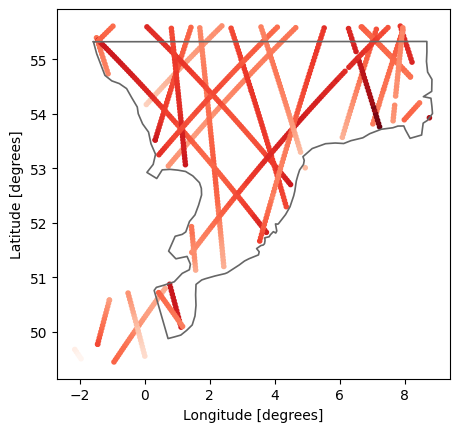

In [8]:
con.plot_observation_positions();

In [9]:
cc = con.extract()

/home/jan/src/modelskill/modelskill/comparison.py:381: UserWarning: no (spatial) overlap between model and observation points
  warnings.warn("no (spatial) overlap between model and observation points")


<AxesSubplot: title={'center': 'HD vs alti'}, xlabel='Observation, Surface Elevation [meter]', ylabel='Model, Surface Elevation [meter]'>

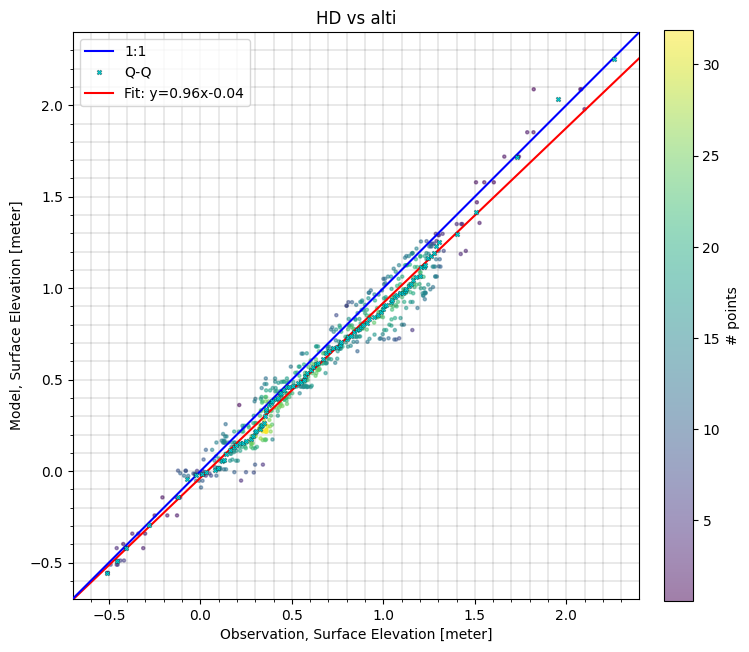

In [10]:
cc['alti'].scatter()

## Extract track from dfs0
ModelResult is now a dfs0

In [11]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ModelResult(fn, name='HD', item=2)
mr.data

/home/jan/src/modelskill/modelskill/utils.py:140: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


,Model_surface_elevation
2017-10-27 10:45:19,0.369932
2017-10-27 10:45:20,0.355970
2017-10-27 10:45:21,0.355910
2017-10-27 10:45:22,0.385431
2017-10-27 10:45:23,0.425780
...,...
2017-10-29 13:10:40,0.723344
2017-10-29 13:10:41,0.706753
2017-10-29 13:10:42,0.706772
2017-10-29 13:10:43,0.706791


In [12]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')

/home/jan/src/modelskill/modelskill/utils.py:140: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


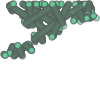

In [13]:
o1.geometry

In [14]:
con = Connector(o1, mr)

In [15]:
o1.data

,x,y,surface_elevation
date,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449
2017-10-26 04:37:54,8.221631,54.948459,1.1200
2017-10-26 04:37:55,8.189390,55.008547,1.0882
2017-10-26 04:37:56,8.157065,55.068627,1.0309
2017-10-26 04:37:58,8.124656,55.128700,1.0369
...,...,...,...
2017-10-30 20:54:43,3.703790,55.363528,0.1111
2017-10-30 20:54:44,3.672147,55.420831,0.0647
2017-10-30 20:54:45,3.640425,55.478128,0.0364


In [16]:
# cc = con.extract()  # TODO: 

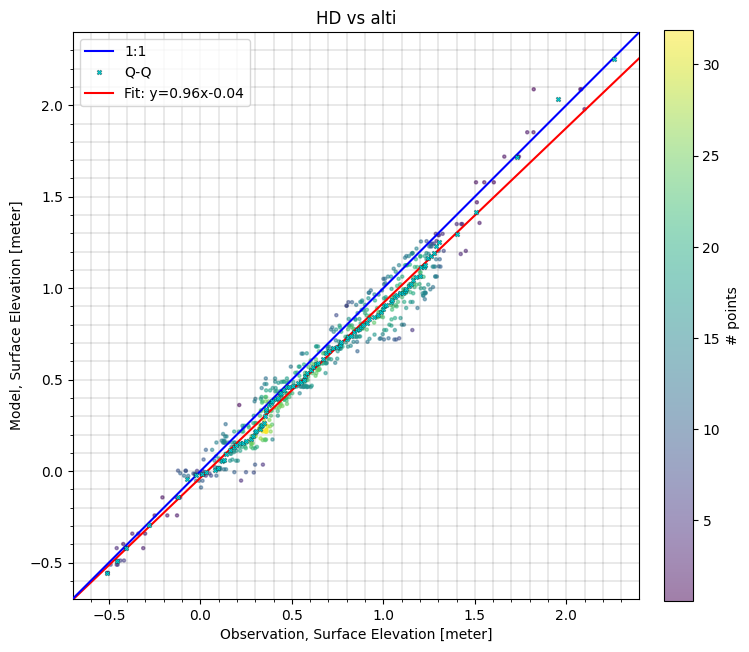

In [17]:
cc['alti'].scatter();

## Spatial skill

Load model, load observation, add observation to model and extract.

In [18]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD', item=0)
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')
con = Connector(o1, mr)
cc = con.extract()

/home/jan/src/modelskill/modelskill/utils.py:140: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(
/home/jan/src/modelskill/modelskill/comparison.py:381: UserWarning: no (spatial) overlap between model and observation points
  warnings.warn("no (spatial) overlap between model and observation points")


Get metrics binned by a regular spatial grid, returns xarray Dataset

In [19]:
ss = cc.spatial_skill(metrics=['bias'])

In [20]:
ss.ds['n']

/home/jan/.local/lib/python3.11/site-packages/xarray/core/indexes.py:555: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  return f"PandasIndex({repr(self.index)})"


<xarray.DataArray 'n' (y: 5, x: 5)>
array([[ 3, 17,  0,  0,  0],
       [ 0, 50,  9,  0,  0],
       [ 0, 36, 51,  0,  0],
       [14, 72, 33, 15, 28],
       [37, 83,  0, 20, 76]])
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
    observation  <U4 'alti'
Attributes:
    long_name:  Number of observations
    units:      -

Plot using xarray - convenient methods coming soon!

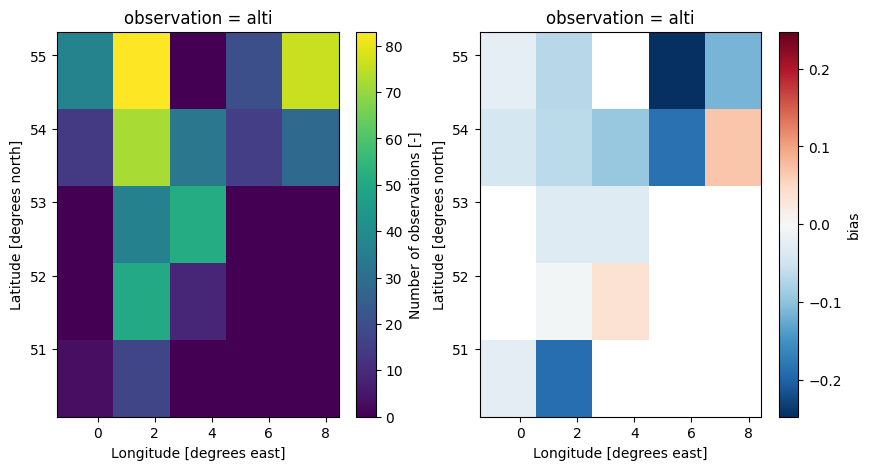

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Minimum number of observations

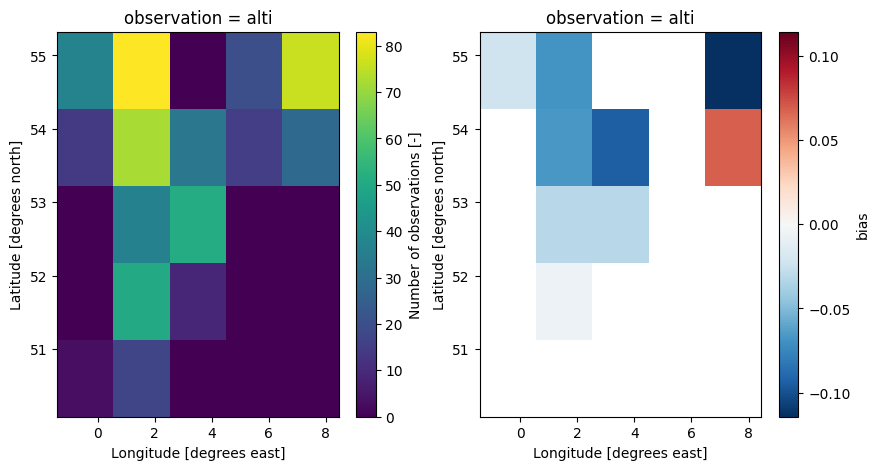

In [22]:
ss = cc.spatial_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Multiple bins - spatial skill for water level categories

Add water level category to comparer's all_df.

In [23]:
all_df = cc.to_dataframe()
all_df['water level'] = 'high'
all_df.loc[all_df['mod_val']<0, 'water level'] = 'low'


Pass custom df with water level category to .spatial_skill and select for 'by'.

In [ ]:
# TODO: temporarily disabled
# ss = cc.spatial_skill(df=all_df, by=['water level'], metrics=['bias'], n_min=5)

In [ ]:
# ss.plot('n');

In [ ]:
# ss.plot('bias');

## Multiple observations

Add fake 2nd observation to model

In [24]:
df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = TrackObservation(df2, item=2, name='alti2')
con.add(o2, mr)

/home/jan/src/modelskill/modelskill/utils.py:140: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


Extract, spatial skill, add attrs, plot.

/home/jan/src/modelskill/modelskill/comparison.py:381: UserWarning: no (spatial) overlap between model and observation points
  warnings.warn("no (spatial) overlap between model and observation points")
/home/jan/src/modelskill/modelskill/comparison.py:381: UserWarning: no (spatial) overlap between model and observation points
  warnings.warn("no (spatial) overlap between model and observation points")


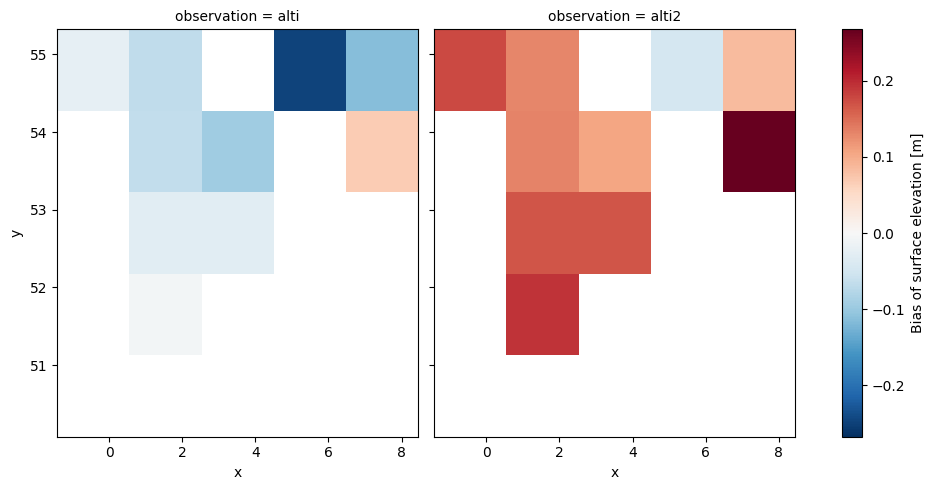

In [25]:
cc = con.extract()
ss = cc.spatial_skill(metrics=['bias'],n_min=20)
ss.ds['bias'].attrs = dict(long_name="Bias of surface elevation",units="m")
ss.plot('bias', figsize=(10,5));